In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import cv2
import time
import json
import pickle

from tensorflow.contrib.keras.python.keras.datasets import mnist
from tensorflow.contrib.keras.python.keras.models import Sequential
from tensorflow.contrib.keras.python.keras.layers.recurrent import SimpleRNN, LSTM, GRU
from tensorflow.contrib.keras.python.keras.optimizers import RMSprop, Adadelta, Adam
from tensorflow.contrib.keras.python.keras.layers import Convolution2D, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.contrib.keras.python.keras.layers.core import Dense, Activation, Dropout, Reshape, Flatten
from tensorflow.contrib.keras.python.keras.layers.wrappers import TimeDistributed
from tensorflow.contrib.keras.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.contrib.keras.python.keras.regularizers import l1, l2
from tensorflow.contrib.keras.python.keras.utils.vis_utils import plot_model
from tensorflow.contrib.keras.python.keras.layers.normalization import BatchNormalization
from tensorflow.contrib.keras.python.keras import models
from tensorflow.contrib.keras.python.keras.models import load_model
from tensorflow.contrib.keras.python.keras.preprocessing.image import ImageDataGenerator

from tensorflow.contrib.keras.python.keras.models import model_from_json

from tensorflow.contrib.keras.python.keras import backend as K

from natsort import natsorted
from IPython.display import clear_output

# VGG-FACE
from tensorflow.contrib.keras.python.keras.preprocessing import image
from tensorflow.contrib.keras.python.keras.engine import Model
# from keras_vggface.vggface import VGGFace

# Confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

K.set_learning_phase(1)

# Settings

In [2]:
TRAIN = 1
REBUILD_DATA = 1
REDEFINE_MODEL = 1

size = 72

n_classes = 7

classes=np.array(('angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'))
# classes=np.array(('angry_disgust', 'fear_surprise', 'neutral_sad', 'happy'))

training_batch_size = 197
testing_batch_size = 197
n_epochs = 200

learning_rate = 0.0001
early_stop_after = 20

# PATH_TRAIN = 'E:/EmotiW2017/train_face_images_cluster'
# PATH_VAL = 'E:/EmotiW2017/val_face_images_cluster'
PATH_TRAIN = 'E:/EmotiW2017/train_face_images'
# PATH_TRAIN = 'D:/Github/afew2016/data/fer2013/train_and_test'
# PATH_VAL = 'D:/Github/afew2016/data/fer2013/test1'
PATH_VAL = 'E:/EmotiW2017/val_face_images'

NPY_X_TRAIN_DATA = 'training_images_x.npy'
NPY_Y_TRAIN_DATA = 'training_images_y.npy'

NPY_X_TEST_DATA = 'testing_images_x.npy'
NPY_Y_TEST_DATA = 'testing_images_y.npy'

MODEL_ARCH_FILE = 'cnn_images_afew2017.json'
WEIGHT_FILE = 'cnn_images_afew2017.hdf5'
MODEL_FILE = 'cnn_images_afew2017.h5'
TRAINING_HIST = 'cnn_images_afew2017.pickle'

# Functions

In [3]:
def emo2int(emo):
    if n_classes == 7:
        if emo == 'Angry':
            return 0
        elif emo == 'Disgust':
            return 1
        elif emo == 'Fear':
            return 2
        elif emo == 'Happy':
            return 3
        elif emo == 'Neutral':
            return 4
        elif emo == 'Sad':
            return 5
        else:
            return 6

In [4]:
def plot_confusion_matrix(y_test, y_pred, classes,
                          normalize=False,
                          title='Unnormalized confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)
    
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)

    thresh = cm.min() + (cm.max() - cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Training data

#### Count # of video in training data

In [5]:
training_y_ = np.array([])

n_vids_train = 0

for emo in os.listdir(PATH_TRAIN):
    full_emo = PATH_TRAIN + '/' + emo
    if os.path.isdir(full_emo):
        for vid in os.listdir(full_emo):
            full_vid = full_emo + '/' + vid

            training_y_ = np.append(training_y_, [int(emo)])

            n_vids_train += 1

print(' > %d images found' % (n_vids_train))

 > 29453 images found


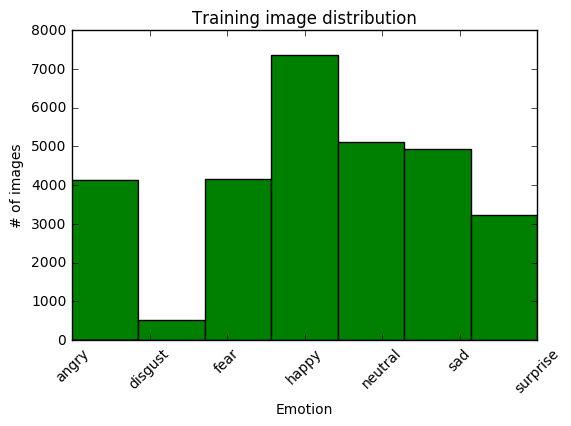

In [6]:
plt.hist(training_y_, bins=n_classes, color='green')
plt.title('Training image distribution')
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.ylabel('# of images')
plt.xlabel('Emotion')
plt.show()

# Validation data

In [7]:
validation_y_ = np.array([])

n_vids_test = 0

for emo in os.listdir(PATH_VAL):
    full_emo = PATH_VAL + '/' + emo
    if os.path.isdir(full_emo):
        for vid in os.listdir(full_emo):
            full_vid = full_emo + '/' + vid
            
            validation_y_ = np.append(validation_y_, [int(emo)])
            
            n_vids_test += 1

print(' > %d images found' % (n_vids_test))

 > 372 images found


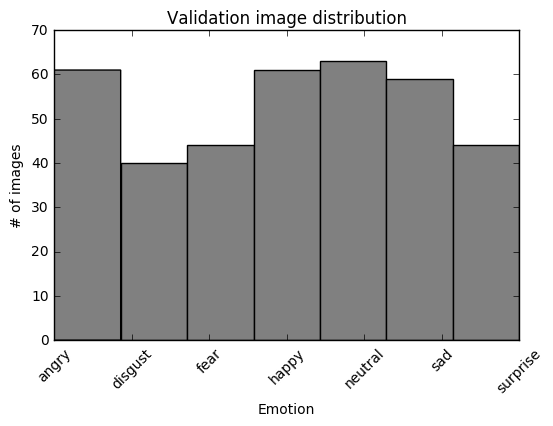

In [8]:
plt.hist(validation_y_, bins=n_classes, color='Gray')
plt.title('Validation image distribution')
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.ylabel('# of images')
plt.xlabel('Emotion')
plt.show()

# CNN

In [9]:
# if os.path.isfile(MODEL_ARCH_FILE) and REDEFINE_MODEL == 0:
#     print('Loading model...', end='')
#     with open(MODEL_ARCH_FILE, 'r') as f:
#         json_string = f.read()
#     model = model_from_json(json_string)
#     print('done.')
# else:
#     print('Defining model...', end='')

#     # Define CNN-LSTM
#     model = Sequential()

#     # ----------- Block 1 ----------- #
#     model.add(Conv2D(16, (3, 3), activation='relu', padding='valid', input_shape=(size, size, 1)))

#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.25))

#     # ----------- Block 2 ----------- #
#     model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
#     model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))

#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.25))

#     # ----------- Block 3 ----------- #
#     model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
#     model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
#     model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))

#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.25))

#     # ----------- Block 4 ----------- #
#     model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
#     model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
#     model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
#     model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.25))

#     # ----------- Block 5 ----------- #
#     model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
#     model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
#     model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
#     model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
#     model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))

#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.25))

#     # ----------- Block 6 ----------- #
#     model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
#     model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
#     model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
#     model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
#     model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
#     model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.25))

#     model.add(Flatten())

#     # ----------- Softmax ----------- #
#     model.add(Dense(1024, activation='relu', kernel_regularizer=l2(0.001)))
#     model.add(Dropout(0.25))
#     model.add(Dense(n_classes, activation='softmax', kernel_regularizer=l2(0.001)))
    
#     with open(MODEL_ARCH_FILE, 'w') as outfile:
#         outfile.write(json.dumps(json.loads(model.to_json()), indent=2))
    
#     print('done.')
    
# print(model.summary())

In [10]:
if os.path.isfile(MODEL_ARCH_FILE) and REDEFINE_MODEL == 0:
    print('Loading model...', end='')
    with open(MODEL_ARCH_FILE, 'r') as f:
        json_string = f.read()
    model = model_from_json(json_string)
    print('done.')
else:
    print('Defining model...', end='')

    # Define CNN-LSTM
    model = Sequential()

    # ----------- Block 1 ----------- #
    model.add(Conv2D(16, (3, 3), activation='relu', padding='valid', input_shape=(size, size, 1)))
    model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))

    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # ----------- Block 2 ----------- #
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))

    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # ----------- Block 3 ----------- #
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))

    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # ----------- Block 4 ----------- #
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))

    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

#     # ----------- Block 5 ----------- #
#     model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
#     model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))

#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.25))

#     # ----------- Block 6 ----------- #
#     model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
#     model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.25))

    model.add(Flatten())

    # ----------- Softmax ----------- #
    model.add(Dense(1024, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.25))
    model.add(Dense(n_classes, activation='softmax', kernel_regularizer=l2(0.001)))
    
    with open(MODEL_ARCH_FILE, 'w') as outfile:
        outfile.write(json.dumps(json.loads(model.to_json()), indent=2))
    
    print('done.')
    
print(model.summary())

Defining model...done.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 70, 70, 16)        160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 70, 70, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 35, 35, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 35, 35, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 35, 35, 32)        4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 35, 35, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 32)      

# Training

In [11]:
if TRAIN == 1:
    start_time = time.time()
    
    # Parameters
    training_batch_size = 512
    testing_batch_size = 1
    n_epochs = 1000
    learning_rate = 0.0001

    # Feedback
    early_stop_after = 20
    early_stopping = EarlyStopping(monitor='val_loss', patience=early_stop_after, verbose=1)
#     checkpointer = ModelCheckpoint(monitor='val_acc', filepath='checkpoints/cnn_images' + '_' + str(size) + '_model.{epoch:05d}-{val_acc:.4f}.hdf5', verbose=1, save_best_only=True)
    checkpointer = ModelCheckpoint(monitor='val_loss', filepath='checkpoints/cnn_images' + '_' + str(size) + '_model.{epoch:05d}-{loss:.4f}-{acc:.4f}-{val_loss:.4f}-{val_acc:.4f}.hdf5', verbose=1, save_best_only=True)
    
    # Data generator
    train_datagen = ImageDataGenerator()
    train_generator = train_datagen.flow_from_directory(
        PATH_TRAIN,
        target_size=(size, size),
        batch_size=training_batch_size,
        class_mode='sparse',
        color_mode='grayscale',
        shuffle=True)
    training_steps_per_epoch = n_vids_train/training_batch_size
    
    val_datagen = ImageDataGenerator()
    val_generator = val_datagen.flow_from_directory(
        PATH_VAL,
        target_size=(size, size),
        batch_size=testing_batch_size,
        class_mode='sparse',
        color_mode='grayscale',
        shuffle=True)
    testing_steps_per_epoch = n_vids_test/testing_batch_size
    
    # Compiling
#     opt = Adam(lr=learning_rate)
    opt = RMSprop(lr=learning_rate)
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Training
    train_history = model.fit_generator(generator=train_generator, steps_per_epoch=training_steps_per_epoch,
                                        validation_data=val_generator, validation_steps=testing_steps_per_epoch,
                                        verbose=1,
                                        epochs=n_epochs,
                                        callbacks=[checkpointer, early_stopping])
    
    training_time = time.time() - start_time
    print('> Training time on GTX1080: ' + str(training_time) + ' sec')

Found 29453 images belonging to 7 classes.
Found 372 images belonging to 7 classes.
Epoch 1/1000
58/57 [==============================] - 413s - loss: 4.4910 - acc: 0.1956 - val_loss: 3.2963 - val_acc: 0.1586
Epoch 2/1000
58/57 [==============================] - 37s - loss: 3.1095 - acc: 0.2342 - val_loss: 3.1650 - val_acc: 0.1640
Epoch 3/1000
58/57 [==============================] - 36s - loss: 2.9379 - acc: 0.2460 - val_loss: 2.9878 - val_acc: 0.1801
Epoch 4/1000
58/57 [==============================] - 35s - loss: 2.7639 - acc: 0.2500 - val_loss: 2.8335 - val_acc: 0.2339
Epoch 5/1000
58/57 [==============================] - 35s - loss: 2.6028 - acc: 0.2668 - val_loss: 2.7080 - val_acc: 0.2177
Epoch 6/1000
58/57 [==============================] - 35s - loss: 2.4677 - acc: 0.2870 - val_loss: 2.6188 - val_acc: 0.2097
Epoch 7/1000
58/57 [==============================] - 35s - loss: 2.3499 - acc: 0.3077 - val_loss: 2.5161 - val_acc: 0.2124
Epoch 8/1000
58/57 [===========================

58/57 [==============================] - 35s - loss: 1.5755 - acc: 0.4895 - val_loss: 2.1071 - val_acc: 0.2581
Epoch 26/1000
58/57 [==============================] - 35s - loss: 1.5556 - acc: 0.4959 - val_loss: 2.1107 - val_acc: 0.2769
Epoch 27/1000
58/57 [==============================] - 35s - loss: 1.5306 - acc: 0.5039 - val_loss: 2.1093 - val_acc: 0.2876
Epoch 28/1000
58/57 [==============================] - 35s - loss: 1.5155 - acc: 0.5090 - val_loss: 2.0914 - val_acc: 0.2930
Epoch 29/1000
58/57 [==============================] - 36s - loss: 1.4884 - acc: 0.5169 - val_loss: 2.1248 - val_acc: 0.2715
Epoch 30/1000
58/57 [==============================] - 35s - loss: 1.4691 - acc: 0.5244 - val_loss: 2.1179 - val_acc: 0.2742
Epoch 31/1000
58/57 [==============================] - 35s - loss: 1.4511 - acc: 0.5302 - val_loss: 2.1115 - val_acc: 0.2446
Epoch 32/1000
58/57 [==============================] - 35s - loss: 1.4238 - acc: 0.5409 - val_loss: 2.1342 - val_acc: 0.2715
Epoch 33/1000


58/57 [==============================] - 35s - loss: 0.8715 - acc: 0.7470 - val_loss: 2.4020 - val_acc: 0.2634
Epoch 58/1000
58/57 [==============================] - 35s - loss: 0.8386 - acc: 0.7584 - val_loss: 2.3342 - val_acc: 0.2742
Epoch 00057: early stopping
> Training time on GTX1080: 2449.59623003006 sec


# Save OR Load model

In [12]:
# TRAIN = 0

if TRAIN == 1:
#     # Save trained model
#     model.save_weights(WEIGHT_FILE)
#     model.save(MODEL_FILE)
#     # Save training history
    with open(TRAINING_HIST, 'wb') as f:
        pickle.dump(train_history.history, f)
        
    history_ = train_history.history
else:
    # Load trained model
    WEIGHT_FILE = 'checkpoints/cnn_images_72_model.00036-1.3195-0.5780-2.0521-0.2957.hdf5'
    model.load_weights(WEIGHT_FILE)
#     model = load_model(MODEL_FILE)
    
    # Load training history
    file = open(TRAINING_HIST, 'rb')
    history_ = pickle.load(file)

In [14]:
# Load trained model
WEIGHT_FILE = 'checkpoints/cnn_images_72_model.00036-1.3195-0.5780-2.0521-0.2957.hdf5'
model.load_weights(WEIGHT_FILE)
# model = load_model(MODEL_FILE)

# Load training history
file = open(TRAINING_HIST, 'rb')
history_ = pickle.load(file)

In [15]:
plot_model(model, to_file='model.png', show_shapes=True)

In [16]:
# # Data generator
# train_datagen_ = ImageDataGenerator()
# train_generator_ = train_datagen_.flow_from_directory(
#     PATH_TRAIN,
#     target_size=(size, size),
#     batch_size=training_batch_size,
#     class_mode='sparse',
#     color_mode='grayscale',
#     shuffle=False)

# val_datagen_ = ImageDataGenerator()
# val_generator_ = val_datagen_.flow_from_directory(
#     PATH_VAL,
#     target_size=(size, size),
#     batch_size=testing_batch_size,
#     class_mode='sparse',
#     color_mode='grayscale',
#     shuffle=False)

In [17]:
# score = model.evaluate_generator(generator=train_generator_, steps=training_steps_per_epoch, pickle_safe=True, workers=1)
# print('Train score:', score[0])
# print('Train accuracy:', score[1])

# score = model.evaluate_generator(generator=val_generator_, steps=testing_steps_per_epoch, pickle_safe=True, workers=1)
# print('Test score:', score[0])
# print('Test accuracy:', score[1])

# Confusion matrix

In [18]:
# y_test
y_pred_training_ = model.predict_generator(generator=train_generator, steps=training_steps_per_epoch, pickle_safe=False, workers=1)
y_pred_ = model.predict_generator(generator=val_generator, steps=testing_steps_per_epoch, pickle_safe=False, workers=1)

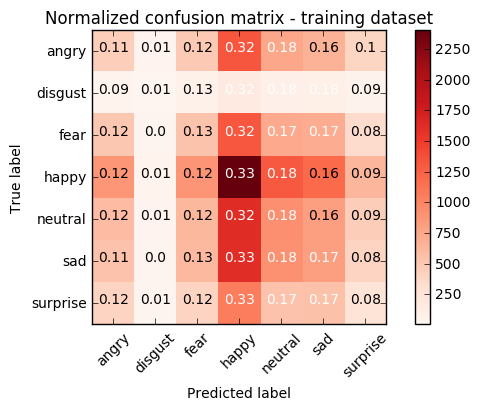

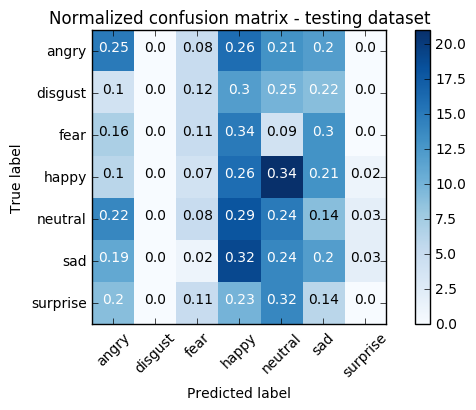

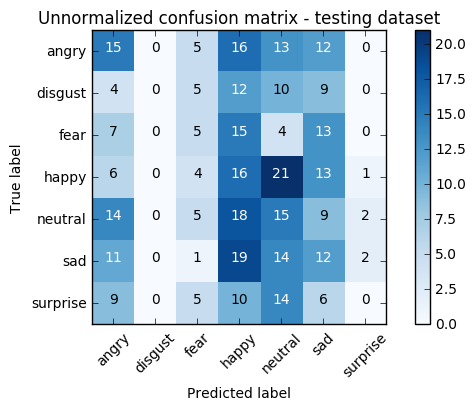

In [21]:
y_pred_training = np.argmax(y_pred_training_, axis=1)
y_pred = np.argmax(y_pred_, axis=1)
# np.sum(y_pred == y_test)/y_test.shape[0]

plot_confusion_matrix(y_test=training_y_, y_pred=y_pred_training,
                      classes=classes,
                      normalize=True,
                      title='Normalized confusion matrix - training dataset',
                      cmap=plt.cm.Reds)

# plot_confusion_matrix(y_test=y_train, y_pred=y_pred_training,
#                       classes=classes,
#                       normalize=False,
#                       title='Unnormalized confusion matrix - training dataset',
#                       cmap=plt.cm.Reds)

plot_confusion_matrix(y_test=validation_y_, y_pred=y_pred,
                      classes=classes,
                      normalize=True,
                      title='Normalized confusion matrix - testing dataset')

plot_confusion_matrix(y_test=validation_y_, y_pred=y_pred,
                      classes=classes,
                      normalize=False,
                      title='Unnormalized confusion matrix - testing dataset')

# Learning history

dict_keys(['loss', 'val_loss', 'acc', 'val_acc'])


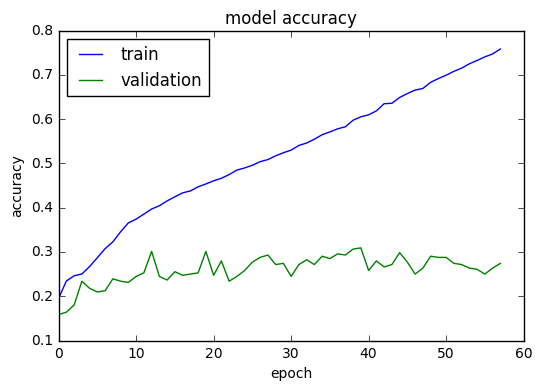

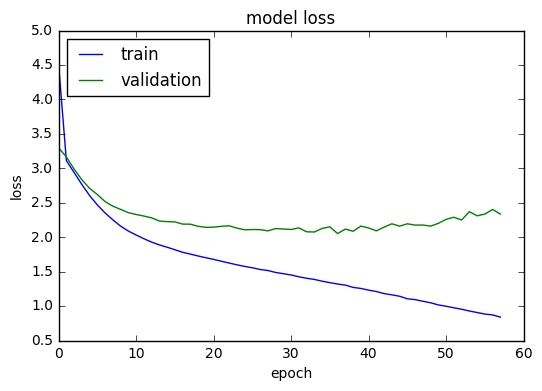

In [20]:
# list all data in history
print(history_.keys())
# summarize history for accuracy
plt.plot(history_['acc'])
plt.plot(history_['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_['loss'])
plt.plot(history_['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()